# Ch8 特徴量の生成と選択

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)
c_list = sns.color_palette().as_hex()
color_num = len(c_list)

## 8.1 簡単な例

In [2]:
df_temp = pd.DataFrame(
    {
        "week":[
            "Mon", "Mon", "Mon", "Tue", "Tue", "Tue", 
            "Wed", "Wed", "Wed", "Thu", "Thu", "Thu", 
            "Fri", "Fri", "Fri", "Sat", "Sat", "Sat", 
            "Sun", "Sun", "Sun", 
        ], 
        "t":[
            "m", "l", "n", "m", "l", "n", 
            "m", "l", "n", "m", "l", "n", 
            "m", "l", "n", "m", "l", "n", 
            "m", "l", "n", 
        ], 
        "temp":[
            35, 52, 15, 37, 52, 15, 37, 54, 16, 39, 51, 12, 
            41, 55, 20, 43, 58, 22, 46, 61, 35
        ]
    }
)
df_temp.set_index(["week", "t"], inplace=True)
display(df_temp)

temp
week t      
Mon  m    35
     l    52
     n    15
Tue  m    37
     l    52
     n    15
Wed  m    37
     l    54
     n    16
Thu  m    39
     l    51
     n    12
Fri  m    41
     l    55
     n    20
Sat  m    43
     l    58
     n    22
Sun  m    46
     l    61
     n    35

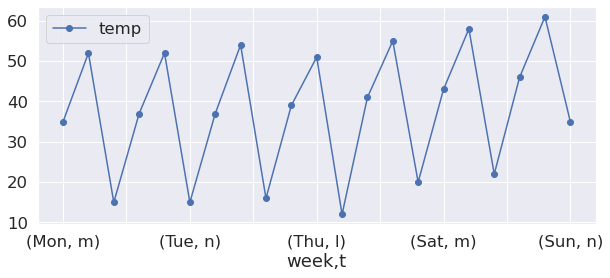

In [3]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
df_temp.plot(y="temp", marker="o", ax=ax);

このような日次の周期と上昇トレンドを持った系列データ。
このデータを要約する特徴量がいくつか考えられる。

## 8.4 特徴量の自動生成と自動選択

In [4]:
#!pip install tsfresh

In [5]:
from tsfresh.examples.robot_execution_failures import (
    download_robot_execution_failures, 
    load_robot_execution_failures
)
from tsfresh import extract_features
import tsfresh

In [6]:
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

display(type(timeseries)) # time series data
display(type(y)) # target vector

pandas.core.frame.DataFrame

pandas.core.series.Series

### robot_execution_failuresデータの確認

このデータが何なのか確認する。

In [7]:
help(tsfresh.examples.robot_execution_failures)

Help on module tsfresh.examples.robot_execution_failures in tsfresh.examples:

NAME
    tsfresh.examples.robot_execution_failures

DESCRIPTION
    This module implements functions to download the Robot Execution Failures LP1 Data Set [1]_, [2]_, [3]_ and load it as
    as DataFrame.
    
    *Important:* You need to download the data set yourself, either manually or via the function
    :func:`~tsfresh.examples.robot_execution_failures.download_robot_execution_failures`
    
    References
    ----------
    .. [1] https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures
    .. [2] Lichman, M. (2013).
        UCI Machine Learning Repository [https://archive.ics.uci.edu/ml].
        Irvine, CA: University of California, School of Information and Computer Science.
    .. [3] Camarinha-Matos, L.M., L. Seabra Lopes, and J. Barata (1996).
        Integration and Learning in Supervision of Flexible Assembly Systems.
        "IEEE Transactions on Robotics and Automation", 12 (2), 202-

`LP1 dataset`というのは[ダウンロード元](https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures)を確認すると、 `LP1: failures in approach to grasp position` と書かれている。

> each failure instance is characterized in terms of 15 force/torque samples collected at regular time intervals starting immediately after failure detection

ということなので、障害検出後のForceとTorqueの計測結果ということ。

`target vector`って何？？

`target vector`については、[tsfreshのDocument](https://tsfresh.readthedocs.io/en/v0.3.0/text/quick_start.html#quick-start-label)に書かれてた。

ロボットが把持を成功させたケース（y=True）と失敗したケース(y=False)でのForceとTorqueの計測結果ということ。

In [8]:
display(timeseries.shape)
display(y.shape)

(1320, 8)

(88,)

In [9]:
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [10]:
timeseries.groupby("id").count()

,time,F_x,F_y,F_z,T_x,T_y,T_z
id,,,,,,,
1,15,15,15,15,15,15,15
2,15,15,15,15,15,15,15
3,15,15,15,15,15,15,15
4,15,15,15,15,15,15,15
5,15,15,15,15,15,15,15
...,...,...,...,...,...,...,...
84,15,15,15,15,15,15,15
85,15,15,15,15,15,15,15
86,15,15,15,15,15,15,15


In [11]:
y.head()

1    True
2    True
3    True
4    True
5    True
dtype: bool

In [12]:
y[~y]

19    False
20    False
21    False
22    False
23    False
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 67, dtype: bool

In [13]:
grp = timeseries.groupby("id")

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
15,2,0,-1,-1,63,-2,-1,0
16,2,1,-1,-1,63,-3,-1,0
17,2,2,-1,-1,61,-3,0,0
18,2,3,0,-4,63,1,0,0
19,2,4,0,-1,59,-2,0,-1
20,2,5,-3,3,57,-8,-3,-1
21,2,6,-1,3,70,-10,-2,-1
22,2,7,0,-3,61,0,0,0
23,2,8,0,-2,53,-1,-2,0
24,2,9,0,-3,66,1,4,0


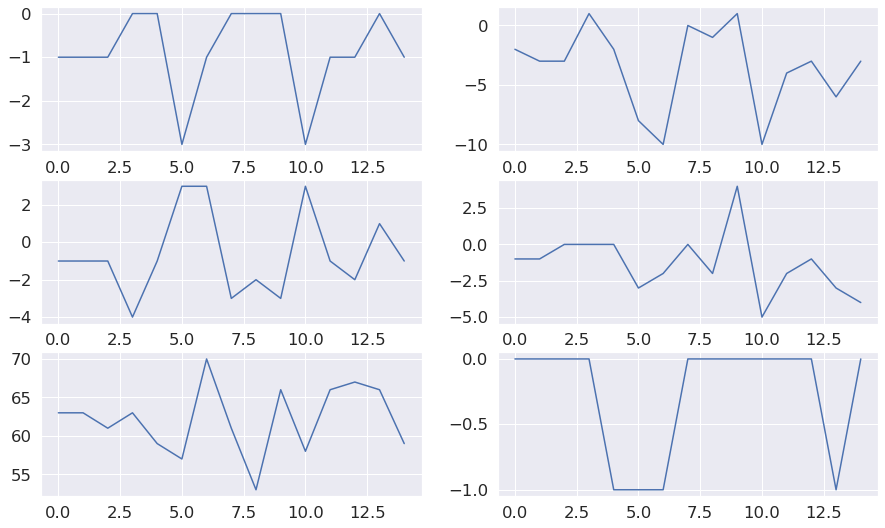

In [14]:
# 成功事例
grp_idx = 2
df_tmp = grp.get_group(grp_idx)

display(df_tmp)

fig = plt.figure(figsize=(15, 3*3))
ax = fig.subplots(3, 2)
ax[0, 0].plot(df_tmp.time, df_tmp.F_x);
ax[0, 1].plot(df_tmp.time, df_tmp.T_x);
ax[1, 0].plot(df_tmp.time, df_tmp.F_y);
ax[1, 1].plot(df_tmp.time, df_tmp.T_y);
ax[2, 0].plot(df_tmp.time, df_tmp.F_z);
ax[2, 1].plot(df_tmp.time, df_tmp.T_z);

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
285,20,0,185,105,118,-180,374,12
286,20,1,-10,5,75,-36,34,-2
287,20,2,-1,-4,43,1,-8,0
288,20,3,-10,-2,64,3,-19,0
289,20,4,0,-2,66,1,0,0
290,20,5,0,1,58,-5,2,-1
291,20,6,0,-5,61,2,-2,1
292,20,7,0,-4,57,1,-4,0
293,20,8,-1,-1,59,-1,-4,0
294,20,9,-1,1,64,-5,-6,1


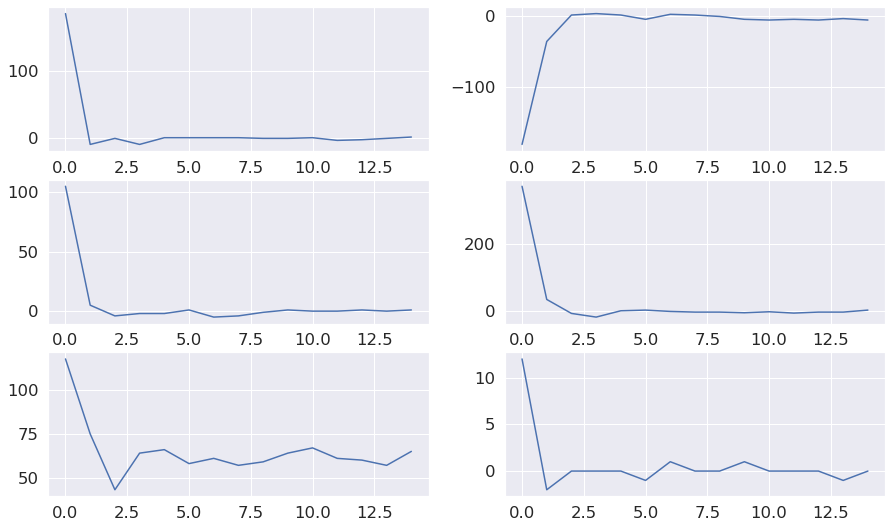

In [15]:
# 失敗事例
grp_idx = 20
df_tmp = grp.get_group(grp_idx)

display(df_tmp)

fig = plt.figure(figsize=(15, 3*3))
ax = fig.subplots(3, 2)
ax[0, 0].plot(df_tmp.time, df_tmp.F_x);
ax[0, 1].plot(df_tmp.time, df_tmp.T_x);
ax[1, 0].plot(df_tmp.time, df_tmp.F_y);
ax[1, 1].plot(df_tmp.time, df_tmp.T_y);
ax[2, 0].plot(df_tmp.time, df_tmp.F_z);
ax[2, 1].plot(df_tmp.time, df_tmp.T_z);

### 特徴量の自動生成

In [16]:
extracted_features = extract_features(
    timeseries, column_id="id", column_sort="time"
)

Feature Extraction: 100%|██████████| 15/15 [00:39<00:00,  2.60s/it]


In [17]:
display(type(extracted_features))
display(extracted_features.columns)
display(extracted_features.shape)

pandas.core.frame.DataFrame

Index(['F_x__variance_larger_than_standard_deviation',
       'F_x__has_duplicate_max', 'F_x__has_duplicate_min',
       'F_x__has_duplicate', 'F_x__sum_values', 'F_x__abs_energy',
       'F_x__mean_abs_change', 'F_x__mean_change',
       'F_x__mean_second_derivative_central', 'F_x__median',
       ...
       'T_z__permutation_entropy__dimension_5__tau_1',
       'T_z__permutation_entropy__dimension_6__tau_1',
       'T_z__permutation_entropy__dimension_7__tau_1',
       'T_z__query_similarity_count__query_None__threshold_0.0',
       'T_z__matrix_profile__feature_"min"__threshold_0.98',
       'T_z__matrix_profile__feature_"max"__threshold_0.98',
       'T_z__matrix_profile__feature_"mean"__threshold_0.98',
       'T_z__matrix_profile__feature_"median"__threshold_0.98',
       'T_z__matrix_profile__feature_"25"__threshold_0.98',
       'T_z__matrix_profile__feature_"75"__threshold_0.98'],
      dtype='object', length=4722)

(88, 4722)

### 特徴量の自動選択

In [18]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

`impute`: 列毎に`NaN`と`Inf`を以下の値に置き換える。

- `-inf` -> `min`
- `+inf` -> `max`
- `NaN` -> `median`

documentは[こちら](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.utilities.html#tsfresh.utilities.dataframe_functions.impute)


In [19]:
impute(extracted_features)
features_filtered = select_features(extracted_features, y)

display(type(features_filtered))
display(features_filtered.columns)
display(features_filtered.shape)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__matrix_profile__feature_"median"__threshold_0.98'
 'T_z__matrix_profile__feature_"25"__threshold_0.98'
 'T_z__matrix_profile__feature_"75"__threshold_0.98'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


pandas.core.frame.DataFrame

Index(['F_x__value_count__value_-1', 'F_x__abs_energy',
       'F_x__root_mean_square', 'F_x__range_count__max_1__min_-1',
       'F_y__root_mean_square', 'F_y__abs_energy', 'T_y__variance',
       'T_y__standard_deviation', 'F_x__fft_coefficient__attr_"abs"__coeff_1',
       'T_y__fft_coefficient__attr_"abs"__coeff_1',
       ...
       'T_x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
       'F_z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'T_x__quantile__q_0.1', 'F_y__has_duplicate_max',
       'F_y__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)',
       'F_y__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)',
       'T_y__quantile__q_0.1', 'F_z__time_reversal_asymmetry_statistic__lag_1',
       'F_x__quantile__q_0.2', 'F_y__quantile__q_0.7'],
      dtype='object', length=676)

(88, 676)

4,722の特徴量が676個にまで削減された。

なお、ここの内容まで[tsfreshのチュートリアル](https://tsfresh.readthedocs.io/en/v0.3.0/text/quick_start.html#quick-start-label)。

### 特徴量の自動選択(sklearn.feature_selection.RFE)

RFEの紹介はしてるのに、実装についての情報が何もない。くそ。

たぶんsklearnと思う。っていうか、[sklearnのドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)に大体同じ例が載ってるな。
インターフェースが固定されてるから同じような実装になるのは仕方がないが、書籍よりも公式のドキュメントを探した方が情報が多いってのはどういうことなんだ？？

In [20]:
import random

In [21]:
x_idx = random.sample(range(len(features_filtered.columns)), 10)
selX = features_filtered.iloc[:, x_idx].values
unselected_features = list(
    set(extracted_features.columns).difference(set(features_filtered.columns))
)
unselected_features = random.sample(unselected_features, 10)
unsel_x_idx = [
    idx for idx, val in enumerate(extracted_features.columns) if val in unselected_features
]
unselX = extracted_features.iloc[:, unsel_x_idx].values
mixed_X = np.hstack([selX, unselX])

In [22]:
display(x_idx)
display(unsel_x_idx)

[16, 251, 146, 437, 508, 89, 116, 567, 264, 165]

[49, 676, 703, 890, 1510, 2485, 2856, 3079, 3789, 4569]

In [23]:
display(type(mixed_X))
mixed_X.shape

numpy.ndarray

(88, 20)

In [24]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

In [25]:
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(mixed_X, y)
rfe.ranking_

array([ 4,  8, 15,  5, 11,  9,  6,  2,  1, 14, 16,  7, 10,  3, 17, 12, 18,
       13, 19, 20])

In [26]:
feature_names = []
for i, r in enumerate(rfe.ranking_):
    if i < 10:
        idx = x_idx[i]
        name = features_filtered.columns[idx]
    else:
        idx = unsel_x_idx[i - 10]
        name = extracted_features.columns[idx]
    feature_names.append(name)

In [27]:
df_mixed_feature_rank =  pd.DataFrame(
    {
        "feature_ranking":rfe.ranking_, 
        "feature_name":feature_names, 
        "is_FRESH_selected":list(np.repeat(True, 10)) + list(np.repeat(False, 10)), 
    }
)
df_mixed_feature_rank.sort_values("feature_ranking")

,feature_ranking,feature_name,is_FRESH_selected
8,1,"F_z__agg_autocorrelation__f_agg_""median""__maxl...",True
7,2,T_y__fourier_entropy__bins_10,True
13,3,"F_y__agg_autocorrelation__f_agg_""var""__maxlag_40",False
0,4,F_x__variance,True
3,5,"F_x__change_quantiles__f_agg_""mean""__isabs_Tru...",True
6,6,F_y__lempel_ziv_complexity__bins_100,True
11,7,F_x__approximate_entropy__m_2__r_0.5,False
1,8,"F_z__change_quantiles__f_agg_""mean""__isabs_Tru...",True
5,9,"F_x__change_quantiles__f_agg_""var""__isabs_True...",True
12,10,"F_x__agg_linear_trend__attr_""intercept""__chunk...",False
